In [1]:
import bs4
from urllib.request import urlopen

In [2]:
# 크롤링 차단 장치 우회를 위해 웹사이트 호출 시 headers 값을 추가
import urllib.request
headers = {
    'User-Agent': 'Mozilla/5.0',
    'X-Requested-With': 'XMLHttpRequest',
}

In [3]:
# url_float = 'http://companyinfo.stock.naver.com/v1/company/c1010001.aspx?cmp_cd=035420'  
url_float = 'https://navercomp.wisereport.co.kr/v2/company/c1010001.aspx?cmp_cd=005930'
# Floating ratio from Naver
url_float

'https://navercomp.wisereport.co.kr/v2/company/c1010001.aspx?cmp_cd=005930'

In [4]:
source = urlopen(url_float).read()   
soup = bs4.BeautifulSoup(source, 'lxml')

//*[@id="cTB11"]/tbody/tr[7]/td

In [5]:
soup.find(id='cTB11').find_all('tr')[6].td.text

'\r\n\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t5,969,782,550주 / 74.63%\r\n\t\t\t\t\t\t\t\t\t\t\t\t\t\t'

In [6]:
tmp = soup.find(id='cTB11').find_all('tr')[6].td.text
tmp = tmp.replace('\r', '')
tmp = tmp.replace('\n', '')
tmp = tmp.replace('\t', '')
tmp

'5,969,782,550주 / 74.63%'

In [7]:
import re

In [8]:
tmp = re.split('/', tmp)
tmp

['5,969,782,550주 ', ' 74.63%']

In [9]:
tmp[0]

'5,969,782,550주 '

In [10]:
tmp[1]

' 74.63%'

In [11]:
outstanding = tmp[0].replace(',', '')
outstanding = outstanding.replace('주', '')
outstanding = outstanding.replace(' ', '')
outstanding

'5969782550'

In [12]:
floating = tmp[1].replace(' ', '')
floating = floating.replace('%', '')
floating

'74.63'

In [13]:
outstanding = int(outstanding)
outstanding

5969782550

In [14]:
floating = float(floating)
floating

74.63

In [15]:
# 구성종목 기본정보
def stock_info(stock_cd):
    url_float = 'http://companyinfo.stock.naver.com/v1/company/c1010001.aspx?cmp_cd=' + stock_cd
    source = urlopen(url_float).read()
    soup = bs4.BeautifulSoup(source, 'lxml')
    
    tmp = soup.find(id='cTB11').find_all('tr')[6].td.text
    tmp = tmp.replace('\r', '')
    tmp = tmp.replace('\n', '')
    tmp = tmp.replace('\t', '')
    
    tmp = re.split('/', tmp)

    outstanding = tmp[0].replace(',', '')
    outstanding = outstanding.replace('주', '')
    outstanding = outstanding.replace(' ', '')
    outstanding = int(outstanding)

    floating = tmp[1].replace(' ', '')
    floating = floating.replace('%', '')
    floating = float(floating)
    
    name = soup.find(id='pArea').find('div').find('div').find('tr').find('td').find('span').text
    
    k10_outstanding[stock_cd] = outstanding
    k10_floating[stock_cd] = floating
    k10_name[stock_cd] = name

In [16]:
'''
한국거래소 시가총액 상위 10종목 (2019년1월 기준)
005930	삼성전자
000660	SK하이닉스
068270	셀트리온
005380	현대차
207940	삼성바이오로직스
051910	LG화학
005490	POSCO
035420	NAVER
017670	SK텔레콤
015760	한국전력
'''
k10_component = ['005930', '000660', '068270', '005380', '207940',\
                 '051910', '005490', '035420', '017670', '015760']

In [17]:
k10_outstanding = dict()
k10_floating = dict()
k10_name = dict()
for stock_cd in k10_component:
    print(stock_cd)
    stock_info(stock_cd)

005930
000660
068270
005380
207940
051910
005490
035420
017670
015760


In [18]:
k10_outstanding

{'005930': 5969782550,
 '000660': 728002365,
 '068270': 137703428,
 '005380': 213668187,
 '207940': 66165000,
 '051910': 70592343,
 '005490': 87186835,
 '035420': 164263395,
 '017670': 72060143,
 '015760': 641964077}

In [19]:
k10_floating

{'005930': 74.63,
 '000660': 74.2,
 '068270': 75.79,
 '005380': 64.43,
 '207940': 24.74,
 '051910': 64.29,
 '005490': 66.45,
 '035420': 80.18,
 '017670': 53.17,
 '015760': 44.8}

과거 주가 구하기 

In [20]:
import datetime as dt
import pandas as pd

In [21]:
def date_format(d):
    d = str(d).replace('-', '.')
    
    yyyy = int(d.split('.')[0]) 
    mm = int(d.split('.')[1])
    dd = int(d.split('.')[2])

    this_date= dt.date(yyyy, mm, dd)
    return this_date

In [22]:
def historical_stock_naver(stock_cd, start_date='', end_date='', page_n=1, last_page=0):
    
    if start_date:   # start_date가 있으면
        start_date = date_format(start_date)   # date 포맷으로 변환
    else:    # 없으면
        start_date = dt.date.today()   # 오늘 날짜를 지정
    if end_date:   # end_date가 없으면 
        end_date = date_format(end_date)   # date 포맷으로 변환
    else:   # end_date가 있으면
        end_date = dt.date.today()   # 오늘 날짜를 end_date로 지정
        
    naver_stock = 'http://finance.naver.com/item/sise_day.nhn?code=' + stock_cd + '&page=' + str(page_n)
    
    # 기존 코드
    # source = urlopen(naver_stock).read()
    
    # 개정 코드 (1줄에서 2줄로 늘어남)
    url = urllib.request.Request(naver_stock, headers=headers)   # headers 정보 보내기
    source = urlopen(url).read()
    
    source = bs4.BeautifulSoup(source, 'lxml')
    
    dates = source.find_all('span', class_='tah p10 gray03')   # 날짜 수집   
    prices = source.find_all('td', class_='num')   # 종가 수집
    
    for n in range(len(dates)):
    
        if len(dates) > 0:
            
            # 날짜 처리
            this_date = dates[n].text
            this_date = date_format(this_date)
            
            if this_date <= end_date and this_date >= start_date:   
            # start_date와 end_date 사이에서 데이터 저장
                # 종가 처리
                this_close = prices[n*6].text
                this_close = this_close.replace(',', '')
                this_close = float(this_close)

                # 딕셔너리에 저장
                historical_prices[this_date] = this_close
                              
            elif this_date < start_date:   
            # start_date 이전이면 함수 종료
                return historical_prices              
            
    # 페이지 네비게이션
    if last_page == 0:
        last_page = source.find_all('table')[1].find('td', class_='pgRR').find('a')['href']
        last_page = last_page.split('&')[1]
        last_page = last_page.split('=')[1]
        last_page = float(last_page)
        
    # 다음 페이지 호출
    if page_n < last_page:
        page_n = page_n + 1
        historical_stock_naver(stock_cd, start_date, end_date, page_n, last_page)   
        
    return historical_prices  

In [23]:
k10_historical_prices = dict()

for stock_cd in k10_component:
    
    historical_prices = dict()
    start_date = '2020-1-1'
    end_date = '2020-12-31'
    historical_stock_naver(stock_cd, start_date, end_date)
    
    k10_historical_prices[stock_cd] = historical_prices

In [24]:
k10_historical_price = pd.DataFrame(k10_historical_prices)
k10_historical_price.sort_index(axis=1, inplace=True) 

In [25]:
k10_historical_price = k10_historical_price.fillna(method='ffill')   # ffill로 구멍을 채우고
if k10_historical_price.isnull().values.any():   # 그래도 구멍이 남아 있으면
    k10_historical_price = k10_historical_price.fillna(method='bfill')   # bfill로 채워라
k10_historical_price.head(3)

,000660,005380,005490,005930,015760,017670,035420,051910,068270,207940
2020-12-30,118500.0,192000.0,272000.0,81000.0,27400.0,238000.0,292500.0,824000.0,359000.0,826000.0
2020-12-29,116000.0,190500.0,270000.0,78300.0,26400.0,237500.0,283000.0,813000.0,360500.0,822000.0
2020-12-28,115500.0,189500.0,273500.0,78700.0,27050.0,247000.0,281000.0,814000.0,333500.0,789000.0


In [26]:
k10_historical_price['005930'] = k10_historical_price['005930'] / 50   # 삼성전자 액면분할에 따른 수정주가 계산
k10_historical_price.head(3)

,000660,005380,005490,005930,015760,017670,035420,051910,068270,207940
2020-12-30,118500.0,192000.0,272000.0,1620.0,27400.0,238000.0,292500.0,824000.0,359000.0,826000.0
2020-12-29,116000.0,190500.0,270000.0,1566.0,26400.0,237500.0,283000.0,813000.0,360500.0,822000.0
2020-12-28,115500.0,189500.0,273500.0,1574.0,27050.0,247000.0,281000.0,814000.0,333500.0,789000.0


지수 산출을 위한 계산

In [27]:
tmp = {'Outstanding' : k10_outstanding,\
       'Floating' : k10_floating,\
       'Price' : k10_historical_price.iloc[0],\
       'Name' : k10_name}
k10_info = pd.DataFrame(tmp)

In [28]:
k10_info['f Market Cap'] = k10_info['Outstanding'] * k10_info['Floating'] * k10_info['Price'] * 0.01
k10_info['Market Cap'] = k10_info['Outstanding'] * k10_info['Price'] * 0.01
k10_info

,Outstanding,Floating,Price,Name,f Market Cap,Market Cap
000660,728002365,74.20,118500.0,SK하이닉스,6.401106e+13,8.626828e+11
005380,213668187,64.43,192000.0,현대차,2.643195e+13,4.102429e+11
005490,87186835,66.45,272000.0,POSCO,1.575850e+13,2.371482e+11
005930,5969782550,74.63,1620.0,삼성전자,7.217503e+12,9.671048e+10
015760,641964077,44.80,27400.0,한국전력,7.880237e+12,1.758982e+11
017670,72060143,53.17,238000.0,SK텔레콤,9.118822e+12,1.715031e+11
035420,164263395,80.18,292500.0,NAVER,3.852412e+13,4.804704e+11
051910,70592343,64.29,824000.0,LG화학,3.739627e+13,5.816809e+11
068270,137703428,75.79,359000.0,셀트리온,3.746719e+13,4.943553e+11
207940,66165000,24.74,826000.0,삼성바이오로직스,1.352098e+13,5.465229e+11


In [29]:
k10_historical_mc = k10_historical_price * k10_info['Outstanding'] * k10_info['Floating'] * 0.01
k10_historical_mc.head(3)

,000660,005380,005490,005930,015760,017670,035420,051910,068270,207940
2020-12-30,6.401106e+13,2.643195e+13,1.575850e+13,7.217503e+12,7.880237e+12,9.118822e+12,3.852412e+13,3.739627e+13,3.746719e+13,1.352098e+13
2020-12-29,6.266062e+13,2.622545e+13,1.564263e+13,6.976919e+12,7.592638e+12,9.099665e+12,3.727291e+13,3.689704e+13,3.762374e+13,1.345550e+13
2020-12-28,6.239053e+13,2.608779e+13,1.584540e+13,7.012561e+12,7.779577e+12,9.463651e+12,3.700950e+13,3.694243e+13,3.480587e+13,1.291532e+13


In [30]:
'''
<데이터프레임>.sum() 은 각 열의 합 (세로방향)
<데이터프레임>.sum(axis=1) 은 각 행의 합 (가로방향)
'''
k10_historical_mc.sum(axis=1)     # 일자별 시가총액 합

2020-12-30    2.573266e+14
2020-12-29    2.534471e+14
2020-12-28    2.502526e+14
2020-12-24    2.528757e+14
2020-12-23    2.513698e+14
                  ...     
2020-01-08    1.653678e+14
2020-01-07    1.660770e+14
2020-01-06    1.645492e+14
2020-01-03    1.662342e+14
2020-01-02    1.672400e+14
Length: 248, dtype: float64

In [31]:
k10 = pd.DataFrame()
k10['K10 Market Cap'] = k10_historical_mc.sum(axis=1)
k10.head(3)

,K10 Market Cap
2020-12-30,2.573266e+14
2020-12-29,2.534471e+14
2020-12-28,2.502526e+14


In [32]:
k10['K10'] = k10['K10 Market Cap'] / k10['K10 Market Cap'][0] * 100
k10.head(3)

,K10 Market Cap,K10
2020-12-30,2.573266e+14,100.000000
2020-12-29,2.534471e+14,98.492376
2020-12-28,2.502526e+14,97.250961


K10 지수 그래프 그리기

In [33]:
import matplotlib.pyplot as plt
%matplotlib inline

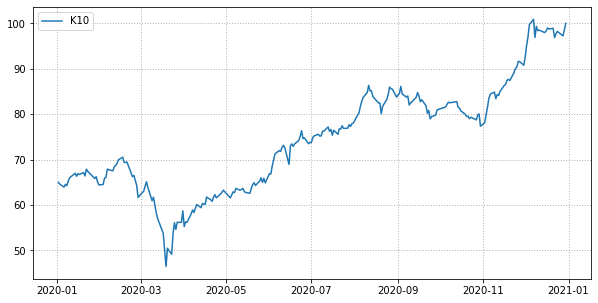

In [43]:
plt.figure(figsize=(10, 5))
plt.plot(k10['K10'], label='K10')
plt.legend(loc=0)
plt.grid(True, color='0.7', linestyle=':', linewidth=1)

KOSPI200과의 비교

In [35]:
def historical_index_naver(index_cd, start_date='', end_date='', page_n=1, last_page=0):
    
    index_cd = index_cd   # 인덱스 코드 
    page_n = page_n   # 페이지 번호 
    
    if start_date:   # start_date가 있으면
        start_date = date_format(start_date)   # date 포맷으로 변환
    else:    # 없으면
        start_date = dt.date.today()   # 오늘 날짜를 지정
    if not end_date:   # end_date가 없으면 
        end_date = dt.date.today()   # 오늘 날짜를 end_date로 지정
    else:   # end_date가 있으면
        end_date = date_format(end_date)   # date 포맷으로 변환
        
    naver_index = 'http://finance.naver.com/sise/sise_index_day.nhn?code=' + index_cd + '&page=' + str(page_n)
    
    # source = urlopen(naver_index).read()   # 지정한 페이지에서 코드 읽기
    
    url = urllib.request.Request(naver_index, headers=headers)   # headers 정보 보내기
    source = urlopen(url).read()
    
    source = bs4.BeautifulSoup(source, 'lxml')   # 뷰티풀 스프로 태그별로 코드 분류
    
    dates = source.find_all('td', class_='date')   # <td class="date">태그에서 날짜 수집   
    prices = source.find_all('td', class_='number_1')   # <td class="number_1">태그에서 지수 수집
    
    for n in range(len(dates)):
    
        if dates[n].text.split('.')[0].isdigit():
            
            # 날짜 처리
            this_date = dates[n].text
            this_date= date_format(this_date)
            
            if this_date <= end_date and this_date >= start_date:   
            # start_date와 end_date 사이에서 데이터 저장
                # 종가 처리
                this_close = prices[n*4].text   # prices 중 종가지수인 0,4,8,...번째 데이터 추출
                this_close = this_close.replace(',', '')
                this_close = float(this_close)

                # 딕셔너리에 저장
                historical_prices[this_date] = this_close
                
            elif this_date < start_date:   
            # start_date 이전이면 함수 종료
                return historical_prices           
            
    # 페이지 네비게이션
    if last_page == 0:
        last_page = source.find('td', class_='pgRR').find('a')['href']
        # 마지막페이지 주소 추출
        last_page = last_page.split('&')[1]   # & 뒤의 page=506 부분 추출
        last_page = last_page.split('=')[1]   # = 뒤의 페이지번호만 추출
        last_page = int(last_page)   # 숫자형 변수로 변환
        
    # 다음 페이지 호출
    if page_n < last_page:   
        page_n = page_n + 1   
        historical_index_naver(index_cd, start_date, end_date, page_n, last_page)   
        
    return historical_prices  

In [36]:
historical_prices = dict()     # 딕셔너리 초기화
kospi200 = historical_index_naver('KPI200', '2020-1-1', '2020-12-31')
kospi200

{datetime.date(2020, 12, 30): 389.29,
 datetime.date(2020, 12, 29): 381.27,
 datetime.date(2020, 12, 28): 379.93,
 datetime.date(2020, 12, 24): 379.18,
 datetime.date(2020, 12, 23): 371.32,
 datetime.date(2020, 12, 22): 366.43,
 datetime.date(2020, 12, 21): 372.18,
 datetime.date(2020, 12, 18): 371.55,
 datetime.date(2020, 12, 17): 372.0,
 datetime.date(2020, 12, 16): 372.53,
 datetime.date(2020, 12, 15): 370.88,
 datetime.date(2020, 12, 14): 371.56,
 datetime.date(2020, 12, 11): 372.24,
 datetime.date(2020, 12, 10): 369.37,
 datetime.date(2020, 12, 9): 371.47,
 datetime.date(2020, 12, 8): 363.45,
 datetime.date(2020, 12, 7): 369.86,
 datetime.date(2020, 12, 4): 367.63,
 datetime.date(2020, 12, 3): 361.66,
 datetime.date(2020, 12, 2): 358.66,
 datetime.date(2020, 12, 1): 352.4,
 datetime.date(2020, 11, 30): 346.05,
 datetime.date(2020, 11, 27): 352.73,
 datetime.date(2020, 11, 26): 352.12,
 datetime.date(2020, 11, 25): 348.3,
 datetime.date(2020, 11, 24): 350.28,
 datetime.date(2020, 1

In [37]:
k200 = pd.DataFrame({'K200' : kospi200})
k200.head(3)

,K200
2020-01-02,290.35
2020-01-03,290.74
2020-01-06,288.43


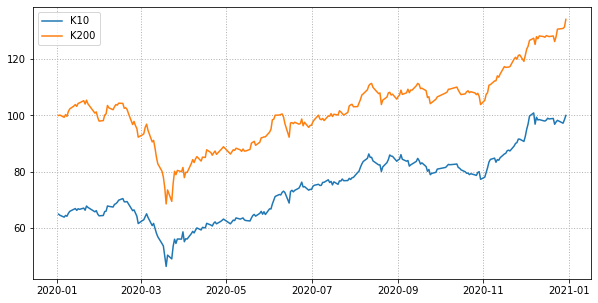

In [44]:
plt.figure(figsize=(10, 5))
plt.plot(k10['K10'] / k10['K10'][0] * 100, label='K10')
plt.plot(k200['K200'] / k200['K200'][0] * 100, label='K200')
plt.legend(loc=0)
plt.grid(True, color='0.7', linestyle=':', linewidth=1)

# K10 선물가격 산출

In [39]:
import math

F = Se^(r-d)t

In [40]:
def futures_price (S, r, d, T, t0):
    t = (T - t0).days / 252
    F = S * math.exp((r-d)*t)
    return F

In [41]:
T = dt.date(2018, 12, 14)     # 만기일
t0 = dt.date(2018, 6, 15)     # 현재일

futures_price (100.0, 0.02, 0.015, T, t0)

100.36176390281524

In [42]:
T = dt.date(2018, 12, 14)     # 만기일
t0 = dt.date(2018, 12, 10)     # 현재일

futures_price (100.0, 0.02, 0.015, T, t0)

100.00793682288563